### CS4501 Final Project

# SARS-CoV-2 Spike Sequence Analysis 

##### Yuchen Sun (ys4aj), Nafisa Amrula (nt8aw)

## Abstract
<p>Ever since the start of the global pandemic SARS-CoV-2, significant amount of experiments have been done to analyze the transmission and virulence of the virus through sequence analysis approach. Our project aims to propose a graphical analysis approach. We take NCBI SARS-CoV-2 dataset collected from the USA since Dec 30, 2020, extract the spike protein coding sequences, conduct pairwise sequence alignment, and analyze the mutation patterns associated with these sequences of multiple variants. Through our graphical analysis, we discovered potential trends of mutation patterns for several variants respectively, and then further studied the type of point mutations associated with these patterns.</p>

## Procedures
*note that some cells may need longer time to run*

### Import Packages

<p>We imported common python data processing packages such as pandas and numpy for faster data processing. We included ncbi.datasets API for directly downloading the SARS-CoV-2 dataset, and used json and jsonline for processing the virus report included in the NCBI datasets.</p>
<p>We used biopython for reading fasta files and conducting pairwise sequence alignment, and we used matplotlib.pyplot as our plotting tool.</p>

In [1]:
import pandas as pd
import numpy as np
import ncbi.datasets
import json
import jsonlines
import zipfile

from Bio import SeqIO
from Bio import pairwise2
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord

from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib.collections import PathCollection
from matplotlib.legend_handler import HandlerPathCollection

### Download from NCBI Datasets

#### Setup connection

In [ ]:
virus_api = ncbi.datasets.VirusApi(ncbi.datasets.ApiClient())

#### Download SARS-CoV-2 Dataset

<p>We limited the geo_location of the sequences to be USA only, and we only included sequences with proper coding region annotations. This is because we would then segment the full sequence according to the provided annotations.</p>

In [ ]:
%%time
viral_genomes = virus_api.virus_genome_download(
    "SARS2",
    annotated_only=True,
    complete_only=True,
    host="human",
    geo_location='USA',
    exclude_sequence=False,
    _preload_content=False
)

zipfn = 'sars_cov2_dataset.zip'
with open(zipfn, 'wb') as f:
    f.write(viral_genomes.data)

print(f'Download complete')
!unzip -v {zipfn}

#### Download SARS-CoV-2 RefSeq

<p>Here we download the official reference sequence from NCBI. The reference sequences is from Wuhan, China, and it will be used as the template of all pairwise alignment through our project.</p>

In [ ]:
%%time
viral_genomes_ref = virus_api.virus_genome_download(
    "SARS2",
    annotated_only=True,
    complete_only=True,
    refseq_only=True,
    host="human",
    exclude_sequence=False,
    _preload_content=False
)

zipfn_ref = 'sars_cov2_refseq.zip'
with open(zipfn_ref, 'wb') as f:
    f.write(viral_genomes_ref.data)

#### Read Virus Report into Pandas DataFrame

<p>We parsed the virus data report provided by NCBI datasets and stored it in pandas dataframe. We only selected a number of important variables from the data report, such as the unique accession number, the sequence release date, the pangolin classification of the sequences, etc. We would further use these variables to limit our dataset. For example, we would only consider the sequence if its full length is no shorter than 29,000 bases, and we would only consider the pangolin classifications with a proper variant name given by WHO.</p>
<p>The same variables are also kept from reading the refseq virus report so that we can properly combine the two dataframes in later processes.</p>
<p>After broadly limiting the full sequences, we retrieved the annotation information for each sequences kept. By accessing the annotations, we located the start and the end site of the spike protein coding sequences, and recorded them in the dataframe. Such process is also done for the refseq. Later, we would use these extracted start and end information to segment each sequences in the dataset so we would have only the spike coding sequences.</p>

In [ ]:
%%time
def get_data_reports(zip_file):
    with zipfile.ZipFile(zip_file, 'r') as zip_download:
        with zip_download.open('ncbi_dataset/data/data_report.jsonl') as report_file_handle:
            with jsonlines.Reader(report_file_handle) as json_reader:
                for g in json_reader:
                    yield g

alpha_variant = ['B.1.1.7']
beta_variant = ['B.1.351']
gamma_variant = ['B.1.1.28.1','P.1']
delta_variant = ['B.1.617.2','XD','XF','XS']
lambda_variant = ['B.1.1.1.37','C.37']
omicron_variant = ['B.1.1.529','B.1.1.529.1','BA.1','B.1.1.529.2','BA.2',
                   'B.1.1.529.3','BA.3','B.1.1.529.4','BA.4','B.1.1.529.5','BA.5']
all_variant = alpha_variant+beta_variant+gamma_variant+delta_variant+lambda_variant+omicron_variant
                    
genome_data = []
for g in tqdm(get_data_reports(zipfn)):
    annot = g['annotation']
    for gene in annot.get('genes', []):
        for c in gene.get('cds', []):
            cds_len = 0
            begins, ends = [], []
            for r in c['nucleotide']['range']:
                begin, end = int(r['begin']), int(r['end'])
                cds_len += end-begin+1
                begins.append(begin)
                ends.append(end)
            genome_data.append({
                'Accession': g['accession'],
                'ReleaseDate': g['releaseDate'],
                'PangoClass': g['virus']['pangolinClassification'],
                'Location': g.get('location', {}).get('geographicLocation'),
                'Length': g.get('length', 0),
                'Gene': gene['name'],
                'Protein': c['name'],
                'Begin': min(begins),
                'End': max(ends),
                'CDS_Length': cds_len,
            })

In [ ]:
df1 = pd.DataFrame(genome_data)
df1 = df1[(df1.Length>=29000)&(df1.PangoClass.isin(all_variant))&(df1.Gene=='S')]
df1.head()

In [ ]:
ref_data = []
for g in tqdm(get_data_reports(zipfn_ref)):
    annot = g['annotation']
    for gene in annot.get('genes', []):
        for c in gene.get('cds', []):
            cds_len = 0
            begins, ends = [], []
            for r in c['nucleotide']['range']:
                begin, end = int(r['begin']), int(r['end'])
                cds_len += end-begin+1
                begins.append(begin)
                ends.append(end)
            ref_data.append({
                'Accession': g['accession'],
                'ReleaseDate': g['releaseDate'],
                'PangoClass': g['virus']['pangolinClassification'],
                'Location': g.get('location', {}).get('geographicLocation'),
                'Length': g.get('length', 0),
                'Gene': gene['name'],
                'Protein': c['name'],
                'Begin': min(begins),
                'End': max(ends),
                'CDS_Length': cds_len,
            })

In [ ]:
df2 = pd.DataFrame(ref_data)
df2 = df2[df2.Gene=='S']
df2

#### Read All Sequences

<p>Read NCBI datasets fasta files using biopython's SeqIO. Sequences is stored in the format of python dictionary, with accession number as keys and sequences as values.</p>

In [ ]:
%%time
def get_sequences(fastafn):
    sequences = {}
    for seq_record in SeqIO.parse(fastafn,'fasta'):
        sequences[seq_record.id] = seq_record.seq
    return sequences

sequences = get_sequences('ncbi_dataset/data/genomic.fna')
refseq = get_sequences('sars_cov2_refseq/ncbi_dataset/data/genomic.fna')
len(sequences)

#### Retrieve Spike Coding Region Sequences

<p>Here, we segmented each of the sequences (including the refseq) using the start and the end location we retrieved earlier through NCBI sequence annotations. We then output these segmented spike coding sequences to a new fasta file for future reads.</p>

In [ ]:
refseq_s_begin, refseq_s_end = df2.Begin.item(), df2.End.item()
refseq_id = df2.Accession.item()
refseq_s = refseq[refseq_id][refseq_s_begin:refseq_s_end+1]
len(refseq_s)

In [ ]:
s_sequences = [
    SeqRecord(
        refseq_s,
        id=refseq_id,
        name='S',
        description='surface glycoprotein, refseq'
    )
]
for seq_id in tqdm(df1.Accession.tolist()):
    data = df1[df1.Accession==seq_id]
    s_sequences.append(
        SeqRecord(
            sequences[seq_id][data.Begin.item():data.End.item()+1],
            id=seq_id,
            name='S',
            description='surface glycoprotein'
        )
    )

#### Output Spike Data to Files

In [ ]:
SeqIO.write(s_sequences, 'sars_cov2_s_genomic.fasta', 'fasta')

In [ ]:
df_s = pd.concat([df2, df1], ignore_index=True)
df_s.head()

In [ ]:
df_s.to_csv('sars_cov2_s_report.csv',index=False)

### Align Spike Sequences

<p>In this part, we read in the previously segmented spike coding sequences and align them so that we can have sequences of the same length for further comparison and analysis. We utilized the biopython's pairwise alignment, and aligned each sequences to the refseq. The output sequences should all have length of 3822, which is the length of the refseq. We then output these aligned sequences (now with special characters such as '-' for misalignment) to a new fasta file for future reads.</p>

#### Load Previously Processed Data

In [ ]:
%%time
fastafn = 'sars_cov2_spike.fasta'
sequences = {}
for seq_record in tqdm(SeqIO.parse(fastafn,'fasta'), desc='loading fasta file'):
    sequences[seq_record.id] = seq_record.seq
print('loaded', len(sequences), 'sequences')

csvfn = 'sars_cov2_spike.csv'
df = pd.read_csv(csvfn)
df.head()

In [ ]:
refseq = sequences['NC_045512.2']
accession_list = df.Accession.tolist()
accession_list.remove('NC_045512.2')
len(accession_list)

#### Pairwise Sequence Alignment

In [ ]:
s_sequences = [
    SeqRecord(
        refseq,
        id='NC_045512.2',
        name='S',
        description='surface glycoprotein, refseq'
    )
]

In [ ]:
for seq_id in tqdm(accession_list, desc='aligning'):
    seq2 = sequences[seq_id]
    alignment = pairwise2.align.globalms(refseq,seq2,2,-1,-10,-0.5,one_alignment_only=True,penalize_end_gaps=False)
    seqB = alignment[0].seqB

    s_sequences.append(
        SeqRecord(
            Seq(seqB),
            id=seq_id,
            name='S',
            description='surface glycoprotein'
        )
    )

#### Output Aligned Sequences to File

In [ ]:
SeqIO.write(s_sequences, 'sars_cov2_spike_aligned.fasta', 'fasta')

### Analyze Mutation Patterns

<p>Here we take the previously aligned sequences and conduct analysis in a base-by-base manner. We would first sort the sequences by its release date in order to capture the trend of changes and variant emergence in a temporal sequence. As we loop through each sequences remaining in our processed database, we loop through each single base with respect to the refseq, and compare the dataset sequences with the refseq in such base-by-base apporach. We record wherever the two bases are different, and plot that difference in a scatter plot. Note that we differentiate these mutations by the variants, so that each variants should have a unique color representing all mutations associated with it. The scatter plot would be shown later in this notebook.</p>
<p>As we discovered the potential pattern of mutations from the scatter plot, we also recorded the type of point mutations from each comparison. We counted the number of mutations from each type of nucleotide to a separate type of nucleotide (e.g. 'A'->'T or 'A'->'C', etc.), and plot the numbers in a bar 3D bar plot, in order to clearly identify unique types of mutations that happens the most in each variant. The bar plots would be shown later in this notebook as well.</p>

#### Load Aligned Data

In [2]:
genomic = './sars_cov2_spike_aligned/sars_cov2_spike_aligned.fasta'
report = './sars_cov2_spike/sars_cov2_spike.csv'

In [3]:
sequences = {}
for seq_record in tqdm(SeqIO.parse(genomic, 'fasta')):
    if len(seq_record.seq) == 3822 and (set(seq_record.seq)<=set(['A','T','C','G','-','N','n'])):
        sequences[seq_record.id] = seq_record.seq

110625it [06:18, 292.56it/s]


In [4]:
df = pd.read_csv(report)
df = df[df.Accession.isin(sequences.keys())]
df = df.sort_values(by='ReleaseDate', ascending=True).reset_index()
df.head()

,index,Accession,ReleaseDate,PangoClass,Location,Length,Gene,Protein,Begin,End,CDS_Length
0,0,NC_045512.2,2020-01-13,B,China,29903,S,surface glycoprotein,21563,25384,3822
1,1,MW422255.1,2020-12-30,alpha,"USA: San Diego, California",29763,S,surface glycoprotein,21500,25312,3813
2,2,MW422256.1,2020-12-30,alpha,USA,29817,S,surface glycoprotein,21524,25336,3813
3,3,MW430966.1,2021-01-04,alpha,USA: California,29835,S,surface glycoprotein,21523,25335,3813
4,4,MW430974.1,2021-01-04,alpha,USA: Florida,29861,S,surface glycoprotein,21551,25363,3813


In [5]:
accession_list = df.Accession.tolist()
accession_list.remove('NC_045512.2')
len_acc = len(accession_list)
refseq = sequences['NC_045512.2']

#### Create Graphic Analysis of Mutation Statistics

<p>We recognized that alpha variant sequences are taking the majority of our datasets, such that it may have a dominant effect on our result. Therefore, we chose to produce two kinds of scatter plot, one that includes the alpha variant in our counts and one that does not. Both plots are shown below.</p>

##### With Alpha Variant

Lambda: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 334/334 [00:02<00:00, 117.57it/s]


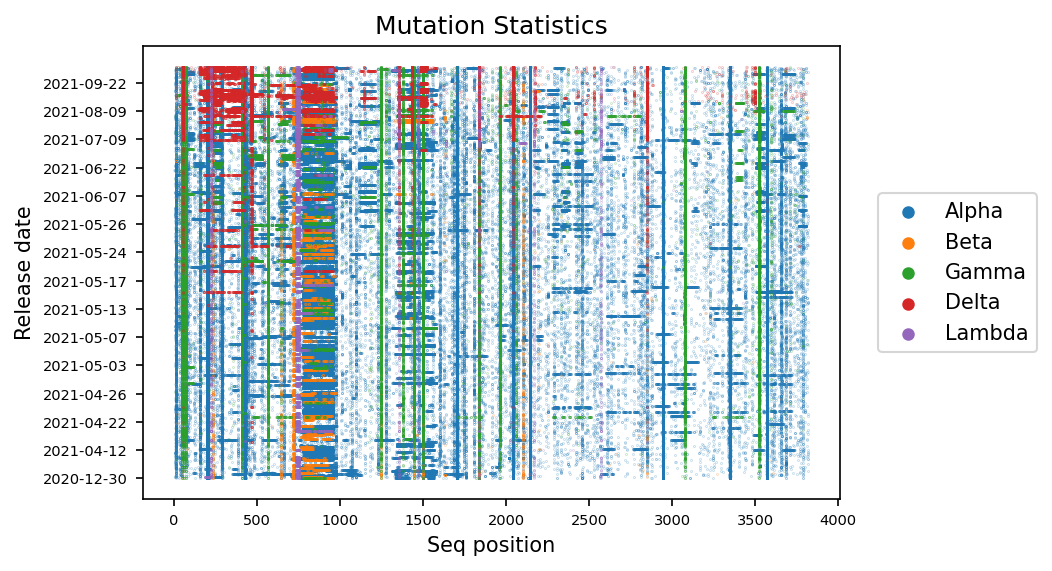

In [6]:
plt.figure(dpi=150)

for var in ['alpha','Beta','Gamma','Delta','Lambda']:
    x, y = [], []
    for i in tqdm(df[df.PangoClass==var].index, desc=var.capitalize()):
        acc = df.iloc[i].Accession
        seq = sequences[acc]
        for j in range(3822):
            if seq[j]!=refseq[j]:
                x.append(j)
                y.append(i)
    plt.scatter(x=x,y=y,label=var.capitalize(),cmap='Set1',s=0.01)

def update_scatter(handle, orig):
    handle.update_from(orig)
    handle.set_sizes([25])

plt.title('Mutation Statistics')
yticks = range(1,len_acc+1,7500)
ylabels = [df.iloc[k].ReleaseDate for k in yticks]
plt.yticks(yticks,ylabels,fontsize=7)
plt.xticks(fontsize=7)
plt.legend(handler_map={PathCollection: HandlerPathCollection(update_func=update_scatter)},
           bbox_to_anchor=(1.04,0.5),loc='center left')
plt.xlabel('Seq position')
plt.ylabel('Release date')
plt.show()

##### Without Alpha Variant

Lambda: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 334/334 [00:03<00:00, 108.19it/s]


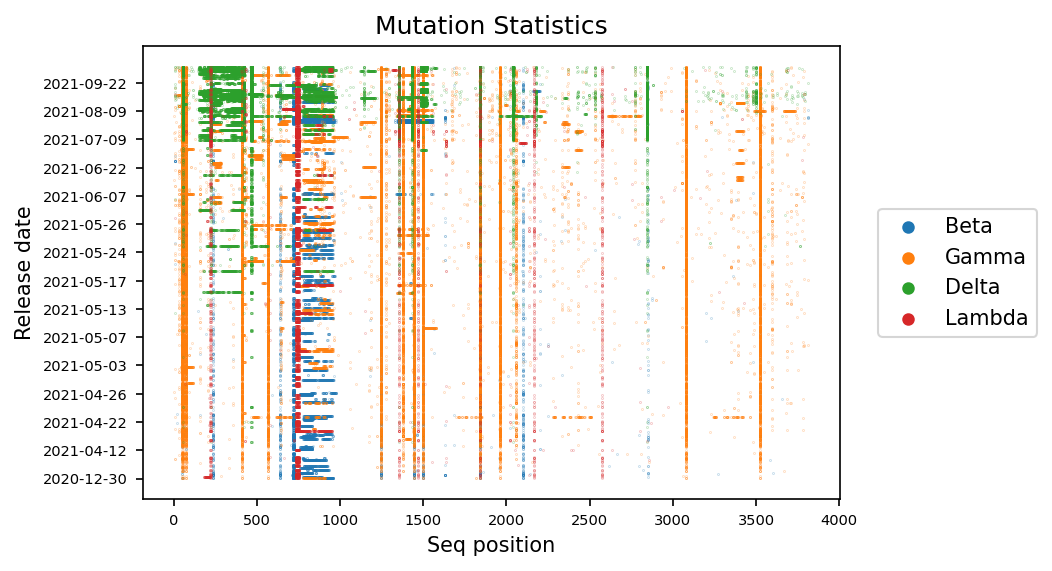

In [7]:
plt.figure(dpi=150)

for var in ['Beta','Gamma','Delta','Lambda']:
    x, y = [], []
    for i in tqdm(df[df.PangoClass==var].index, desc=var.capitalize()):
        acc = df.iloc[i].Accession
        seq = sequences[acc]
        for j in range(3822):
            if seq[j]!=refseq[j]:
                x.append(j)
                y.append(i)
    plt.scatter(x=x,y=y,label=var.capitalize(),cmap='Set1',s=0.01)

def update_scatter(handle, orig):
    handle.update_from(orig)
    handle.set_sizes([25])

plt.title('Mutation Statistics')
yticks = range(1,len_acc+1,7500)
ylabels = [df.iloc[k].ReleaseDate for k in yticks]
plt.yticks(yticks,ylabels,fontsize=7)
plt.xticks(fontsize=7)
plt.legend(handler_map={PathCollection: HandlerPathCollection(update_func=update_scatter)},
           bbox_to_anchor=(1.04,0.5),loc='center left')
plt.xlabel('Seq position')
plt.ylabel('Release date')
plt.show()

##### Probability of Different Point Mutations

<p>Here we produce the 3D bar plots for showing the probabilities of different types of point mutations in each variant respectively. We chose to have probabilities instead of plain counts as our z-axis variable for the reason that the alignment gives plenty of shifts in the sequences. Such high occurance of misalignment would blur the actual potential point mutations if we only use simple counts. Therefore, we calculated the probabilities for each kind of mutations, and ignored the shifts in producing these bar plots. The bar plots are shown below.</p>

Alpha: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 99327/99327 [03:59<00:00, 414.47it/s]


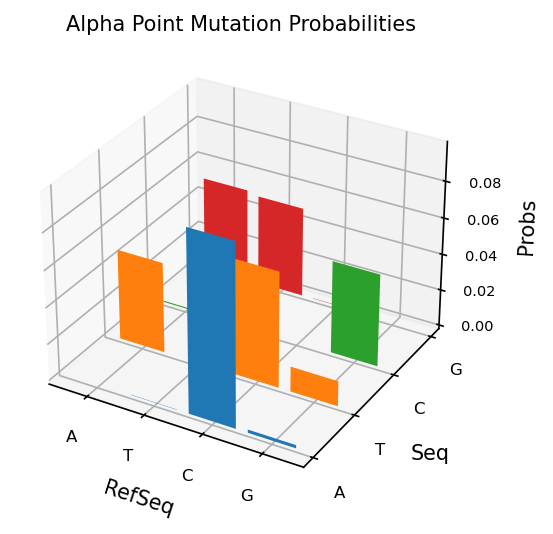

Beta: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 359/359 [00:00<00:00, 401.13it/s]


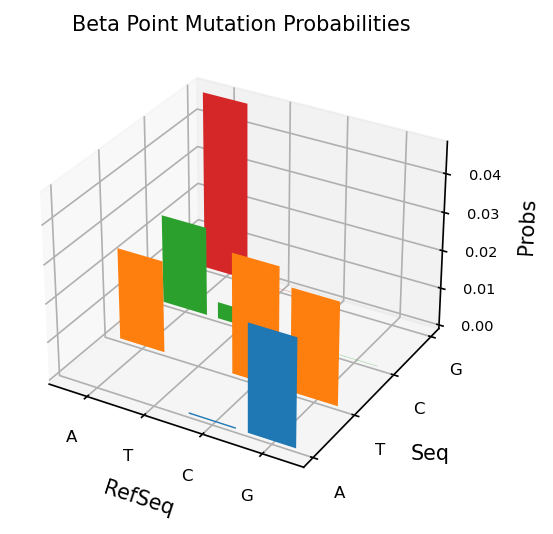

Gamma: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 5553/5553 [00:13<00:00, 401.43it/s]


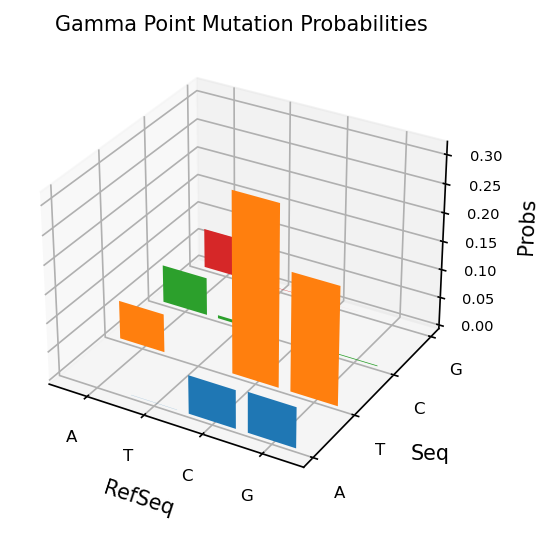

Delta: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3714/3714 [00:08<00:00, 413.94it/s]


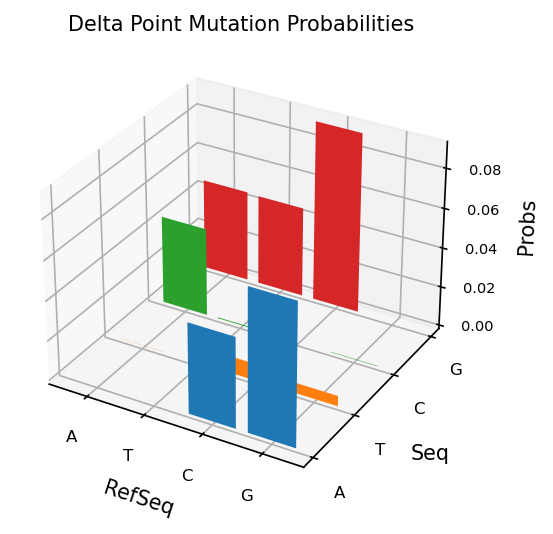

Lambda: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 334/334 [00:00<00:00, 399.32it/s]


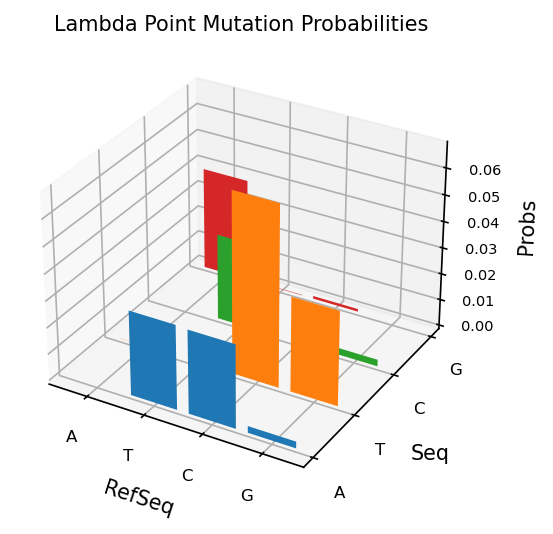

In [10]:
basedict = {
    'A': 0, 'T': 1, 'C': 2, 'G': 3
}
ticks = ['A','T','C','G']

for var in ['alpha','Beta','Gamma','Delta','Lambda']:
    changes = np.zeros((5,5))
    for i in tqdm(df[df.PangoClass==var].index, desc=var.capitalize()):
        acc = df.iloc[i].Accession
        seq = sequences[acc]
        for j in range(3822):
            if seq[j]!=refseq[j]:
                x = basedict[refseq[j]] if refseq[j] in basedict.keys() else 4
                y = basedict[seq[j]] if seq[j] in basedict.keys() else 4
                changes[x,y] += 1
    changes = changes/np.sum(changes)
    fig = plt.figure(dpi=150)
    ax = fig.add_subplot(projection='3d')
    for x in range(4):
        ys = np.arange(4)
        xs = changes[:,x][:4]
        ax.bar(ys, xs, zs=x, zdir='y')
    ax.set_xlabel('RefSeq')
    ax.set_ylabel('Seq')
    ax.set_zlabel('Probs')
    ax.set_xticks(range(4),ticks,fontsize=8)
    ax.set_yticks(range(4),ticks,fontsize=8)
    plt.setp(ax.get_zticklabels(),fontsize=7)
    plt.title(var.capitalize()+' Point Mutation Probabilities', fontsize=10)
    plt.show()

## Discussion

The sequence data downloaded from NCBI allows us to decode the mutation-induced transmission and infection behavior of COVID-19. In this analysis, we downloaded 110625 complete SARS-CoV-2 genome sequences origin in the US from [NCBI](https://www.ncbi.nlm.nih.gov/datasets/coronavirus/genomes/) up to October, 2021. Given the limitations of the data processing power of our machines, we filtered the dataset to contain the specific protein-coding sequence.

<p>We produced the graphs shown above after all procedures introduced were performed. As we analyze the first scatter plot showing all mutations in our database, we clearly discovered a pattern associated with each variant. However, we recognized that the alpha variant is taking the majority of the mutations as over 85% of our sequences are categorized as alpha Pango-Class. We therefore removed alpha from the scatter plot to analyze other variants, and the pattern associated with them were enhanced. We discovered that beta variants are more likely to have point mutations from base position 700 to 900, where as lambda variants are more likely to have short segments of mutations at regions around base position 750. Furthermore, we can capture that the delta variant, with its concentrated emergence from date 2021-07-09, has multiple mutations in two regions: base position 100-500 and base position 750 to 900. The gamma variants have more dispersed mutation patterns, but are very conserved in each sequences. From these observations, we are able to presume that the change of sequences in the region of base position 750-900 is likely to have crucial effect on the spike protein expression, and thus affecting the functions of the virus entry to human cells.</p>

<p>We then studied the probability of each point mutations with respect to each variant, and discovered several hidden patterns. For example, in alpha variants, most point mutations are associated with a single base change from Cytosine to Adenine, where as in beta variants, the base change of Adenine to Guanine contributed to a significant proportion of all poiint mutations. Gamma variants point mutation patterns are similar to lambda mutation patterns. Both are mostly characterized by the base change of Cytosine to Thymine. Moreover, delta variants point mutations has two outstanding patterns: Guanine to Adenine and Cytosine to Guanine. The exact effects of such base changes in the level of protein sequences and protein functions are not yet understood by the nature of our project, but we presume that it might induce some changes in key amino acids, and therefore change the secondary or tertiary structure of the final protein.</p>

<p>We believe that our project can be further applied to studying other protein coding regions of the SARS-CoV-2 virus. This can be done by changing the parameters during the annotation processing. In addition, the sequence alignments and mutation pattern study can also be conducted in a protein / amino acid sequence level, where the patterns discovered may have a stronger link to the functionality difference of the corresponding virus component. Overall, we are confident that our approach can provide unique perspectives on studying the SARS-CoV-2 sequences in the future.</p>